# Markov chain Monte Carlo sampling

## Markov chain

- General idea: search locally instead of globally

### Detailed balance

The probability of being in state $x$ and transitioning from $x$ to $x^\prime$ must equal the probability of being in state $x^\prime$ and transitioning from $x^\prime$ to $x$.

$$p(x) T(x^\prime \mid x) = p(x^\prime) T(x \mid x^\prime)$$

## The Metropolis Hastings algorithm

Separate the transition into two steps:

1. Propose a new point based on a proposal distribution $q(x^\prime \mid x)$.
2. Accept or reject the new point.

### General case

1. Propose a new point $x^\prime$ based on the current point $x_t$ and a proposal distribution $q(x^\prime \mid x_t)$.
2. Calculate the acceptance probability:
   $$A(x^\prime, x_t) = \min\left(1, \frac{p(x^\prime)}{p(x_t)}\frac{q(x_t \mid x^\prime)}{q(x^\prime \mid x_t}\right)$$
3. Generate a sample $u$ from $U(0, 1)$.
   - If $u \leq A(x^\prime, x_t)$: accept the new state. → $x_{t+1} = x^\prime$.
   - If $u \gt A(x^\prime, x_t)$: reject the new state. → $x_{t+1} = x_t$.
  
### Symmetric proposal distribution


In [1]:
%config InlineBackend.figure_format = 'svg'

In [2]:
import scipy.stats as stats
from metropolishastings import sample_metropolis_hastings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from myst_nb import glue

In [3]:
def draw_proposal_sample(x, proposal_cov):
    # Draws a sample from a Normal proposal distribution centered at `x` with standard deviation `proposal_std`
    return stats.multivariate_normal(mean=x, cov=proposal_cov).rvs()


def compute_proposal_logpdf(x, y, proposal_cov):
    # Computes the PDF value of proposing `y` given `x` in the proposal distribution
    return stats.multivariate_normal(mean=x, cov=proposal_cov).logpdf(y)

# Define the target distribution
def evaluate_target_pdf(x):
    """Target distribution with two peaks."""
    return 0.3 * np.exp(-0.2 * (x - 2) ** 2) + 0.7 * np.exp(-0.2 * (x + 2) ** 2)

In [4]:
# Parameters for the algorithm
num_samples = 1000
proposal_cov = 80
start_value = 40

# Run the Metropolis-Hastings algorithm
samples = sample_metropolis_hastings(
    start_value,
    compute_target_logpdf=lambda x: np.log(evaluate_target_pdf(x)),
    compute_proposal_logpdf=compute_proposal_logpdf,
    draw_proposal_sample=draw_proposal_sample,
    num_samples=num_samples,
    proposal_cov=proposal_cov,
)


Acceptance probability:
   $$A(x^\prime, x_t) = \min\left(1, \frac{p(x^\prime)}{p(x_t)}\right)$$


## Practical considerations

### Burn-in

- Initial samples are still influenced by the starting point and not representative for the distribution
- To speed up convergence, remove these samples: "burn-in" period


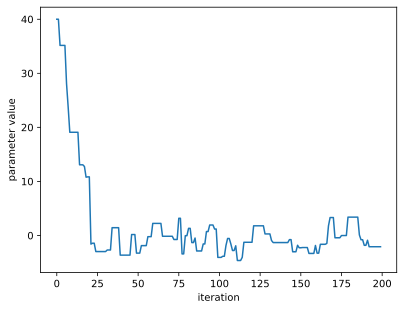

In [5]:
plt.plot(samples[:200])
plt.xlabel("iteration")
plt.ylabel("parameter value")
glue("mcmc_burnin_plot", plt.gcf(), display=False)

```{glue:figure} mcmc_burnin_plot
:width: 100%
:name: "fig-mcmc-burnin"

This is a **caption**.
```



### Autocorrelation

- the more local approach of MCMC comes at the cost of generating correlated instead of independent samples: Samples are more similar to the ones generated directly before or after them.
- The correlation of samples means that the information content is lower than in the same amount of independent samples → lower effective samples size
- Thinning: only keep every nth sample to reduce autocorrelation



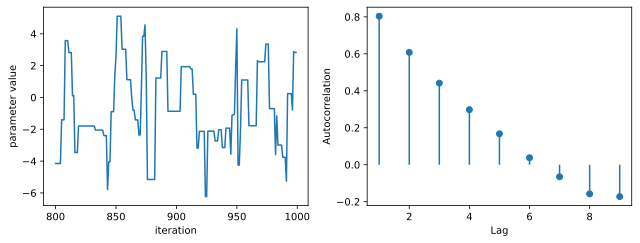

In [6]:
slice = range(800, 1000)

fig, axs = plt.subplots(1, 2, figsize=(9, 3.5))
axs[0].plot(slice, samples[slice])
axs[0].set_xlabel("iteration")
axs[0].set_ylabel("parameter value");


def autocorrelation(x, lag):
    return np.corrcoef(x[:-lag], x[lag:])[0, 1]

# Calculate autocorrelations for each lag
lags = range(1, 10)
autocorrs = [autocorrelation(samples[slice], lag) for lag in lags]

# Plot
axs[1].stem(lags, autocorrs, basefmt=" ")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.tight_layout()
glue("mcmc_autocorrelation_plot", plt.gcf(), display=False)

```{glue:figure} mcmc_autocorrelation_plot
:width: 100%
:name: "fig-mcmc-autocorelation"

This is a **caption**.
```




### Tuning the proposal distribution

- MH-sampling works better if the proposal distribution is adapted to what the target distribution looks like
- for example, scale the variance of a (symmetric) proposal distribution to influence the step size
- Or use a multivariate normal with covariance as a proposal distribution
- estimate the local covariance from already existing samples
- "adaptive" Metropolis Hastings


### Step size & acceptance rate

- Too small step size: sampler hardly moves, explores distribution very locally. Almost all samples get accepted, but exploring the whole parameter space takes very long → inefficient
- Too large step size: Proposed samples are very far away, basically become random. This leads to a very low acceptance rate  → many samples wasted
- Ideally, sample size should be somewhere in between. Theoretical calculations show that an acceptance rate of about 23% is optimal.



In [7]:
# Parameters for the algorithm
num_samples = 1000
proposal_cov = 0.05
start_value = 0

# Run the Metropolis-Hastings algorithm
samples_small_cov = sample_metropolis_hastings(
    start_value,
    compute_target_logpdf=lambda x: np.log(evaluate_target_pdf(x)),
    compute_proposal_logpdf=compute_proposal_logpdf,
    draw_proposal_sample=draw_proposal_sample,
    num_samples=num_samples,
    proposal_cov=proposal_cov,
)

# Parameters for the algorithm
num_samples = 1000
proposal_cov = 2000
start_value = 0

# Run the Metropolis-Hastings algorithm
samples_large_cov = sample_metropolis_hastings(
    start_value,
    compute_target_logpdf=lambda x: np.log(evaluate_target_pdf(x)),
    compute_proposal_logpdf=compute_proposal_logpdf,
    draw_proposal_sample=draw_proposal_sample,
    num_samples=num_samples,
    proposal_cov=proposal_cov,
)



/tmp/ipykernel_197619/1872811529.py:24: RuntimeWarning: divide by zero encountered in log
  compute_target_logpdf=lambda x: np.log(evaluate_target_pdf(x)),


In [8]:
def compute_acceptance_rate(samples):
    return (np.diff(samples[500:]) != 0).mean()

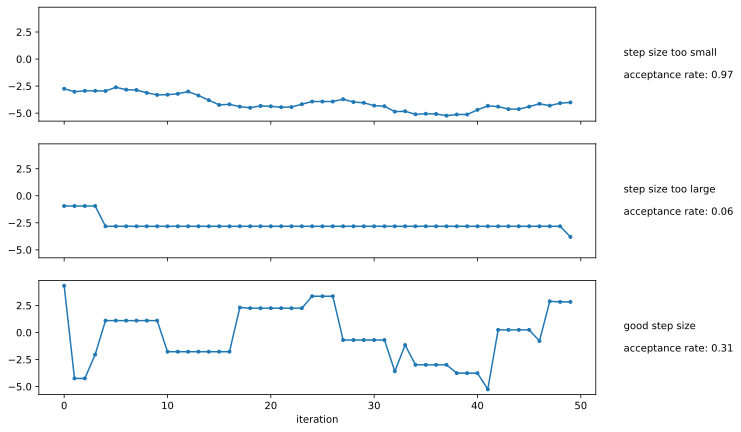

In [9]:
fig, axs = plt.subplots(3, 1, figsize=(10, 7), sharey=True, sharex=True)
axs[0].plot(samples_small_cov[-50:], marker=".", label="step size too small")
axs[0].annotate(
    text=f"step size too small\n\nacceptance rate: {compute_acceptance_rate(samples_small_cov):.2f}",
    xy=(1.05, 0.5),
    xycoords="axes fraction",
    va="center"
)
axs[1].plot(samples_large_cov[-50:], marker=".", label="step size too large")
axs[1].annotate(
    text=f"step size too large\n\nacceptance rate: {compute_acceptance_rate(samples_large_cov):.2f}",
    xy=(1.05, 0.5),
    xycoords="axes fraction",
    va="center"
)
axs[2].plot(samples[-50:], marker=".", label="step size good")
axs[2].annotate(
    text=f"good step size\n\nacceptance rate: {compute_acceptance_rate(samples):.2f}",
    xy=(1.05, 0.5),
    xycoords="axes fraction",
    va="center"
)

plt.xlabel("iteration")

glue("mcmc_acceptance_rate_plot", fig, display=False)

```{glue:figure} mcmc_acceptance_rate_plot
:width: 100%
:name: "fig-mcmc-acceptance-rate"

This is a **caption**.
```



## Alternative sampling algorithms

### Gibbs sampling

### DREAM

### Hamiltonian Monte Carlo